In [1]:
import mdtraj as md
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import statsmodels.api as sm
from matplotlib import animation
from IPython.display import HTML
import matplotlib
from scipy.interpolate import interp1d
from scipy import interpolate
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [5]:
plt.rcParams['font.family'] = "Helvetica"
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

In [6]:
def deal_pbc():
    global xyz_pro, table_pro, traj
    
    chain1_center = np.mean(xyz_pro[:,table_pro.chainID==0,:],axis=1)
    chain2_center = np.mean(xyz_pro[:,table_pro.chainID==1,:],axis=1)
    chain3_center = np.mean(xyz_pro[:,table_pro.chainID==2,:],axis=1)

    for j in range(3):
        pbc_cross_1 = np.where(abs(chain1_center[:,j] - chain2_center[:,j])>4)
        for i in range(len(pbc_cross_1[0])):
            if(chain2_center[pbc_cross_1[0][i],j] - chain1_center[pbc_cross_1[0][i],j] > 0):
                xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] = xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] - traj.unitcell_lengths[pbc_cross_1[0][i],j]
            else:
                xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] = xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] + traj.unitcell_lengths[pbc_cross_1[0][i],j]

        pbc_cross_2 = np.where(abs(chain1_center[:,j] - chain3_center[:,j])>4)
        for i in range(len(pbc_cross_2[0])):
            if(chain3_center[pbc_cross_2[0][i],j] - chain1_center[pbc_cross_2[0][i],j] > 0):
                xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] = xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] - traj.unitcell_lengths[pbc_cross_2[0][i],j]
            else:
                xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] = xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] + traj.unitcell_lengths[pbc_cross_2[0][i],j]
    
    return xyz_pro

    

In [7]:
def read_traj(index):
    
    global traj, xyz_pro, table_pro, table
    
    traj = md.load_xtc('run%d/sys_hydro_run_10.xtc'%index, top = 'initial_promb.pdb')
    xyz = traj.xyz
    top = traj.topology
    table, bonds = top.to_dataframe()
    
    table.loc[ table.chainID==0, 'resSeq'] = table['resSeq'][table.chainID==0].values + 815
    table.loc[ table.chainID==1, 'resSeq'] = table['resSeq'][table.chainID==1].values + 815
    table.loc[ table.chainID==2, 'resSeq'] = table['resSeq'][table.chainID==2].values + 815

    table.loc[ table.chainID==3, 'resSeq'] = table['resSeq'][table.chainID==3].values + 685
    table.loc[ table.chainID==4, 'resSeq'] = table['resSeq'][table.chainID==4].values + 685
    table.loc[ table.chainID==5, 'resSeq'] = table['resSeq'][table.chainID==5].values + 685
    
    table_pro =  table[table.chainID < 3]
    xyz_pro = xyz[:,table.chainID < 3,:]
    
    xyz_pro = deal_pbc()
    
    loc_start = 500
    
    xyz_fp = xyz_pro[500:,(table_pro.resSeq==816)&(table_pro.name=='BB'),:]
    xyz_tm = np.mean(xyz_pro[500:,(table_pro.resSeq==1214)&(table_pro.name=='BB'),:],axis=1)
    xyz_tm2 = np.mean(xyz_pro[500:,(table_pro.resSeq==1237)&(table_pro.name=='BB'),:],axis=1)
    
    reach = (np.linalg.norm((xyz_fp - xyz_tm[:,np.newaxis,:]), axis=2)).ravel()
    v1 = xyz_tm - xyz_tm2
    v2 = xyz_fp - xyz_tm2[:,np.newaxis,:]
    
    angle = np.zeros(np.shape(reach))
    count = 0
    for i in range(np.shape(v1)[0]):
        for j in range(3):
            v_fp = v2[i,j,:]
            v_tm = v1[i,:]
            angle[count] = np.arccos(np.dot(v_fp,v_tm)/np.linalg.norm(v_fp)/np.linalg.norm(v_tm)) / np.pi * 180
            count = count + 1
    
    pos_temp = xyz_fp - xyz_tm[:,np.newaxis,:]
    pos = pos_temp.reshape((np.shape(pos_temp)[0]*np.shape(pos_temp)[1],3))
    
    return reach, angle, pos
    
    
    

In [8]:
index_array = [1,2,3,4,5]
reach = np.zeros((5,4503))
angle = np.zeros((5,4503))
pos_x = np.zeros((5,4503))
pos_y = np.zeros((5,4503))
pos_z = np.zeros((5,4503))

for j in range(len(index_array)):
    reach_temp, angle_temp, pos_temp  = read_traj(index_array[j])
    reach[j,:] = reach_temp
    angle[j,:] = angle_temp
    pos_x[j,:] = pos_temp[:,0]
    pos_y[j,:] = pos_temp[:,1]
    pos_z[j,:] = pos_temp[:,2]


Text(0, 0.5, 'pdf')

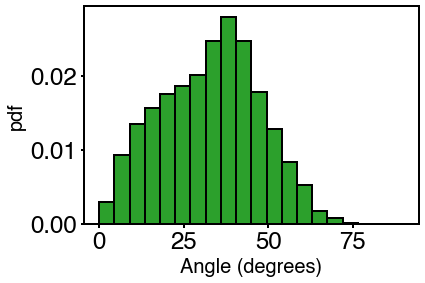

In [9]:
n, bins, patches = plt.hist(angle.ravel(),bins=np.linspace(0,90,21), density=True, facecolor='tab:green',edgecolor='k',linewidth=2)
plt.xlabel('Angle (degrees)')
plt.ylabel('pdf')

Text(0, 0.5, 'r (nm)')

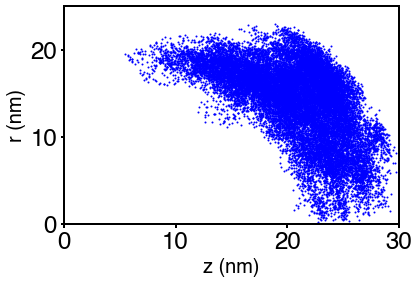

In [10]:
pos_r = np.sqrt(pos_x**2 + pos_y**2)
plt.plot(pos_z.ravel(), pos_r.ravel(),'bo',ms=1)
plt.xlim([0,30])
plt.ylim([0,25])
plt.xlabel('z (nm)')
plt.ylabel('r (nm)')

Text(0, 0.5, 'pdf')

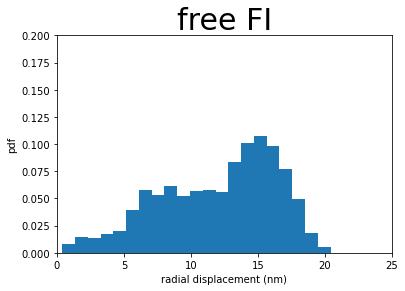

In [10]:
r_ravel = pos_r[(pos_z>=23)&(pos_z<=25)].ravel()
plt.hist(r_ravel,bins=21,density=True)
plt.xlim([0,25])
plt.ylim([0,0.2])
plt.title('free FI',fontsize=30)
plt.xlabel('radial displacement (nm)')
plt.ylabel('pdf')

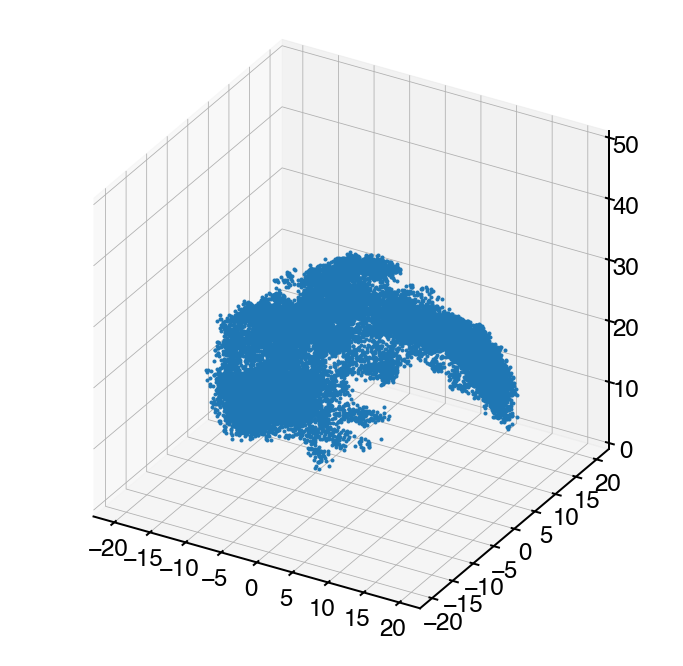

In [12]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.set_proj_type('ortho')
#ax.axis('off')
    
'''
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([pos_x.max()-pos_x.min(), pos_y.max()-pos_y.min(), pos_z.max()-pos_z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(pos_x.max()+pos_x.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(pos_y.max()+pos_y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(pos_z.max()+pos_z.min())
    
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')
'''


plot1, = ax.plot3D([],[],[],'o',ms=3,alpha=1,c='tab:blue')
ax.auto_scale_xyz([-20,20], [-20,20], [0,50])
plot1.set_data_3d(pos_x.ravel(), pos_y.ravel(), pos_z.ravel()) 
    
#ax.view_init(elev=0.)

Text(0, 0.5, 'y (nm)')

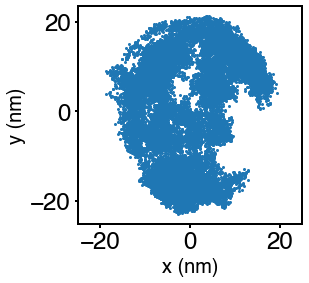

In [13]:
#plt.figure(figsize=(6,6))
#for i in range(5):
#    plt.plot(pos_x[i,:], pos_y[i,:],'o',ms=2)
#fig, ax=plt.subplots(figsize=(5,5))
plt.plot(pos_x.ravel(),pos_y.ravel(),'o',ms=2)

#ax.set_aspect('equal',adjustable='box')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-25,25])
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')

#plt.plot([0],[0],'ko',ms=4)

In [14]:
np.shape(xyz_tm)

NameError: name 'xyz_tm' is not defined

(0.0, 35.0)

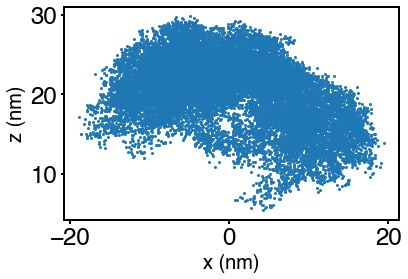

In [28]:
#plt.figure(figsize=(6,6))
#for i in range(5):
#    ax.plot(pos_x[i,:], pos_z[i,:],'o',ms=2)
plt.plot(pos_x.ravel(), pos_z.ravel(),'o',ms=2)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x (nm)')
plt.ylabel('z (nm)')
ax.set_ylim([0,35])

#plt.axis('equal')

Text(0, 0.5, 'z (nm)')

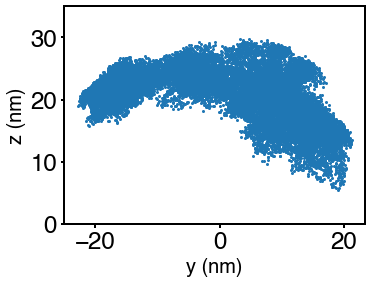

In [17]:

#for i in range(5):
#    ax.plot(pos_y[i,:], pos_z[i,:],'o',ms=2)
plt.plot(pos_y.ravel(), pos_z.ravel(), 'o', ms=2)
plt.gca().set_aspect('equal',adjustable='box')
plt.ylim([0,35])
plt.xlabel('y (nm)')
plt.ylabel('z (nm)')

(0.0, 30.0)

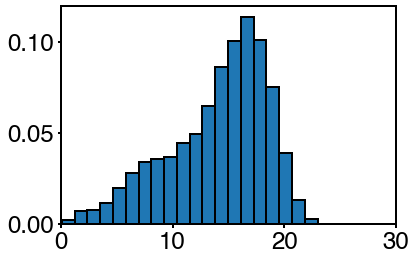

In [42]:
n, bins, patches = plt.hist(np.sqrt(pos_x.ravel()**2 + pos_y.ravel()**2),bins=20, density=True, linewidth=2,facecolor='tab:blue',edgecolor='k')
plt.xlim([0,30])

In [14]:
np.shape(pos_x)

(5, 3003)

(0.0, 30.0)

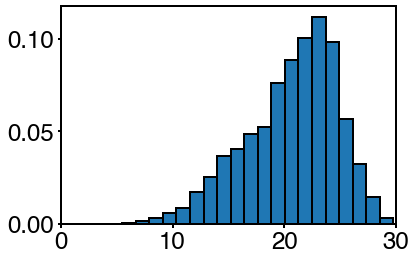

In [41]:
n, bins, patches = plt.hist(pos_z.ravel(),bins=20, density=True,facecolor='tab:blue',edgecolor='k', linewidth = 2)
plt.xlim([0,30])

[]

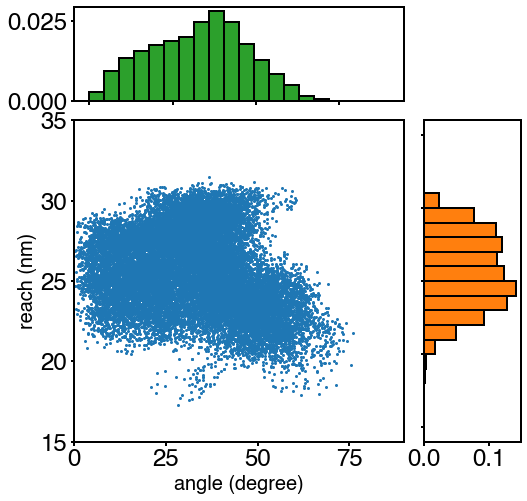

In [13]:
fig = plt.figure(figsize=(8,8))
from matplotlib.gridspec import GridSpec
gs = GridSpec(4,4)

scatter_axes = fig.add_subplot(gs[1:4,0:3])
x_hist_axes = fig.add_subplot(gs[0,0:3])
y_hist_axes = fig.add_subplot(gs[1:4,3])



#scatter_axes = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)
#x_hist_axes = plt.subplot2grid((4, 4), (0, 0), colspan=3,
#                               sharex=scatter_axes)
#y_hist_axes = plt.subplot2grid((4, 4), (1, 3), rowspan=3,
#                               sharey=scatter_axes)

#for i in range(5):
#    scatter_axes.plot(angle[i,:], reach[i,:], 'o',ms=2)
scatter_axes.plot(angle.ravel(), reach.ravel(), 'o',ms=2)
scatter_axes.set_xlim(0,90)
scatter_axes.set_ylim(15,35)
scatter_axes.set_xlabel('angle (degree)')
scatter_axes.set_ylabel('reach (nm)')

n, bins, patches = x_hist_axes.hist(angle.ravel(),bins=np.linspace(0,90,21), density=True, facecolor='tab:green',edgecolor='k',linewidth=2)
x_hist_axes.set_xticklabels([])


n, bins, patches = y_hist_axes.hist(reach.ravel(),bins=np.linspace(15,35,21), density=True, facecolor='tab:orange',edgecolor='k', orientation='horizontal',linewidth=2)
y_hist_axes.set_yticklabels([])

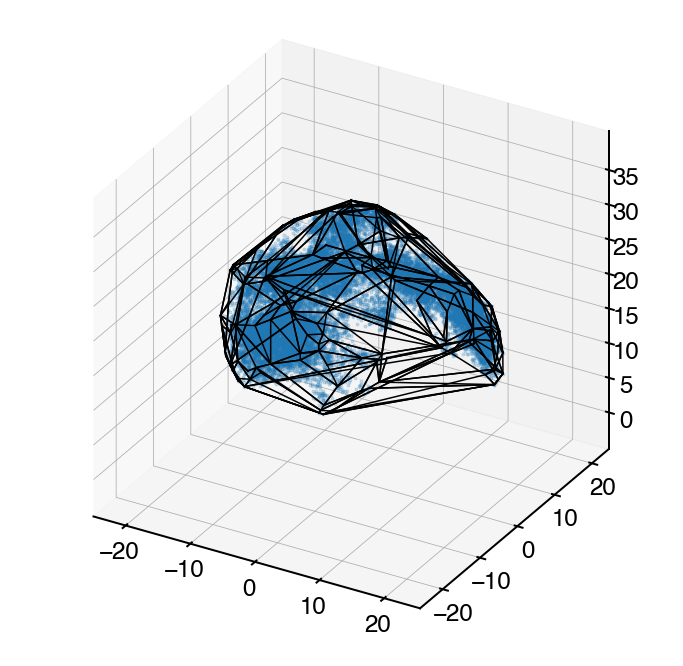

In [132]:
from scipy.spatial import ConvexHull
points = np.array([pos_x,pos_y,pos_z]).T
hull = ConvexHull(points)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.set_proj_type('ortho')
#ax.axis('off')
    

# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([pos_x.max()-pos_x.min(), pos_y.max()-pos_y.min(), pos_z.max()-pos_z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(pos_x.max()+pos_x.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(pos_y.max()+pos_y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(pos_z.max()+pos_z.min())
    
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')
    
plot1, = ax.plot3D([],[],[],'o',ms=3,alpha=0.2,c='tab:blue')
plot1.set_data_3d(pos_x, pos_y, pos_z) 
    
#ax.view_init(elev=0.)

for simplex in hull.simplices:
    ax.plot3D(points[simplex, 0], points[simplex, 1], points[simplex, 2], 'k-')


In [133]:
volume = ConvexHull(points).volume
volume

15654.790787437227

In [41]:
np.mean(angle)

32.904831540646114

In [42]:
np.std(angle)

14.556682244507138

In [43]:
np.mean(reach)

25.61631227925754

In [44]:
np.std(reach)

2.5050542263125446

(0.0, 60.0)

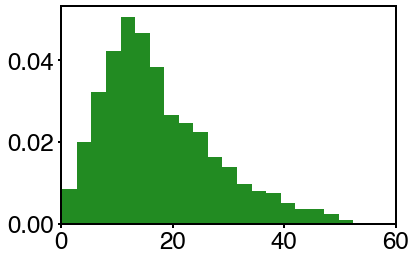

In [27]:
a = plt.hist(angle,density=True,bins=20,color='forestgreen')
plt.xlim([0,60])

(22.0, 33.0)

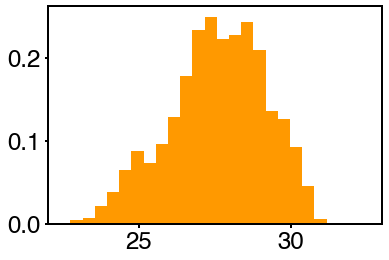

In [25]:
b = plt.hist(reach,density=True,bins=21,color='#FF9900')
plt.xlim([22,33])

In [29]:
np.max(pos_z)

29.44999885559082

In [30]:
4588**(1/3)

16.61656062514368